dataset from https://www.kaggle.com/c/titanic

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [35]:
train = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/train.csv'
                    , error_bad_lines=False)
test = pd.read_csv('https://raw.githubusercontent.com/smcconn5/Portfolio/master/Datasets/Titanic%20Project/test.csv'
                    , error_bad_lines=False)

Titanic = pd.concat([train, test],sort=True)

train.head()


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Since the test dataset doesn't include the survived column, we'll perform an analysis on the training dataset.

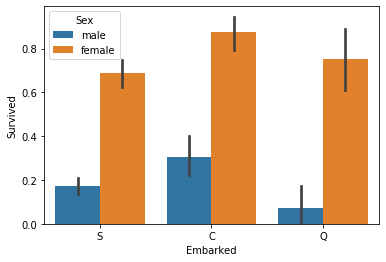

In [36]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train);

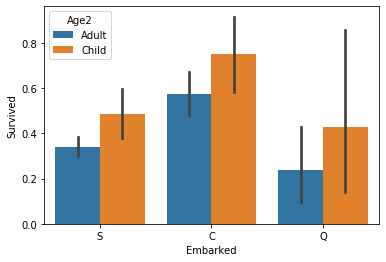

In [23]:
#Let's create a category variable to show if the passenger was a child or not base on the age (less than 18).
train.loc[df['Age'] < 18, 'Age2'] = 'Child' 
train.loc[df['Age'] >= 18, 'Age2'] = 'Adult' 
sns.barplot(x="Embarked", y="Survived", hue="Age2", data=train);

### We can see that women's survival rates far exceeded the men's survival rate, which means that passengers onboard the Titanic did in fact abide by the Birkenhead Drill, or Women and Children first.

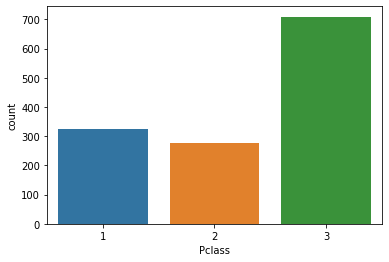

In [37]:
sns.countplot(x="Pclass", data=Titanic)
#Majority of the passengers were third class, the 2nd most passengers were first class, and the least passengers were second class.

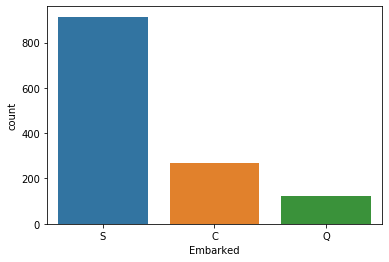

In [40]:
sns.countplot(x="Embarked", data=Titanic)
#Majority of passengers came from Southampton

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


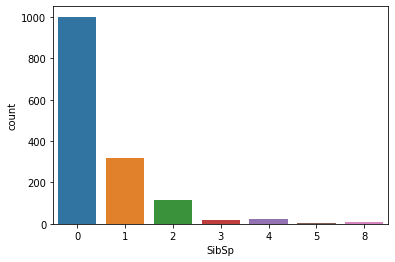

In [45]:
sns.countplot(x="Parch", data=Titanic)


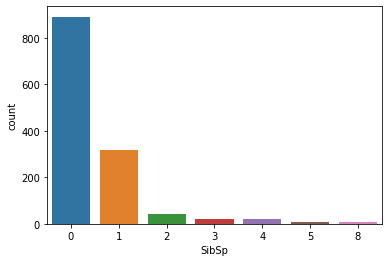

In [44]:
sns.countplot(x="SibSp", data=Titanic)

In [34]:
print(train.shape)
print(test.shape)
print(combined.shape)
print(train.info())
#There's a significant number of missing cabin numbers. Age is also problematic because it's missing almost 200 observations.
#Embarked is only missing 2 observations

(891, 12)
(418, 11)
(1309, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
